In [2]:
# Install necessary packages
!pip install pandas openpyxl plotly seaborn

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

In [3]:
# Load Data

# Upload the Excel file
from google.colab import files
uploaded = files.upload()

# The file will be uploaded to the current directory
# Verify upload
import os
print("Uploaded files:", list(uploaded.keys()))

Saving 0post-LHH_arch24.xlsx to 0post-LHH_arch24.xlsx
Uploaded files: ['0post-LHH_arch24.xlsx']


In [5]:
# Load and Examine Data

# Load the Excel file
filename = '0post-LHH_arch24.xlsx'  # Replace with your actual filename
df = pd.read_excel(filename, sheet_name='Extracted 2025-03-31', header=3)

# Basic data exploration
print("Dataset Shape:", df.shape)
print("\nColumn Names:")
print(df.columns.tolist())
print("\nFirst 5 rows:")
print(df.head())
print("\nData Types:")
print(df.dtypes)
print("\nMissing Values:")
print(df.isnull().sum())

Dataset Shape: (193628, 19)

Column Names:
['EstablishmentID', 'EstablishmentNumber', 'EstablishmentName', 'InspectionDate', 'InspectionTypeCategory', 'ShiftTypeId', 'InspectionTaskCode', 'InspectionTaskName', 'TaskID', 'RegsVerified', 'RegsVerifiedCount', 'NonComplianceId', 'NRNumber', 'NRRegs', 'NRRegsCount', 'NRDescription', 'MOINumber', 'MOIDate', 'MOIDescription']

First 5 rows:
   EstablishmentID EstablishmentNumber  \
0             2478                M85B   
1             4642   M7455+P7455+V7455   
2             5605                M934   
3             6667         M9400+P9400   
4             6667         M9400+P9400   

                                   EstablishmentName InspectionDate  \
0  Swift Pork Company                            ...     2023-10-01   
1  Williams Sausage Company, Inc.                ...     2023-10-01   
2  Charlie DiMaria & Son Inc                     ...     2023-10-01   
3  Cargill Meat Solutions Corporation            ...     2023-10-01   
4  Ca

In [7]:
# Data Preprocessing

# Clean and Prepare Data

# Clean column names (remove extra spaces)
df.columns = df.columns.str.strip()

# Handle missing values in key columns
df['EstablishmentNumber'] = df['EstablishmentNumber'].fillna('UNKNOWN')
df['EstablishmentName'] = df['EstablishmentName'].fillna('Unknown Facility')
df['InspectionTypeCategory'] = df['InspectionTypeCategory'].fillna('Unknown')

# Create binary violation indicator
df['HasViolation'] = df['NRNumber'].notna() & (df['NRNumber'] != '')

# Remove the line causing the error as InspectionDate is already datetime
# df['InspectionDate_Clean'] = pd.to_datetime('1900-01-01') + pd.to_timedelta(df['InspectionDate'] - 2, unit='D')


print("Data preprocessing completed!")
print(f"Total records: {len(df):,}")
print(f"Records with violations: {df['HasViolation'].sum():,}")
print(f"Violation rate: {df['HasViolation'].mean()*100:.2f}%")

Data preprocessing completed!
Total records: 193,628
Records with violations: 790
Violation rate: 0.41%


In [8]:
# Create Violation Details

# Extract and clean violation information
df['ViolatedRegulations'] = df['NRRegs'].fillna('')
df['ViolationDescription'] = df['NRDescription'].fillna('')

# Split violated regulations into lists
def split_regulations(reg_string):
    if pd.isna(reg_string) or reg_string == '':
        return []
    return [reg.strip() for reg in str(reg_string).split(',')]

df['RegulationsList'] = df['ViolatedRegulations'].apply(split_regulations)
df['RegulationCount'] = df['RegulationsList'].apply(len)

print("Violation details extracted!")

Violation details extracted!


In [11]:
# Establishment Performance Aggregation

# Calculate Performance Metrics

# Group by establishment and calculate performance metrics
establishment_performance = df.groupby(['EstablishmentNumber', 'EstablishmentName']).agg(
    EstablishmentID=('EstablishmentID', 'first'),
    TotalInspections=('InspectionDate', 'count'),  # Total inspections
    ViolationCount=('HasViolation', 'sum'),  # Violation count
    ViolationRate=('HasViolation', 'mean'),  # Violation rate
    RoutineInspections=('InspectionTypeCategory', lambda x: (x == 'Routine').sum()),  # Routine inspections
    TotalRegulationsViolated=('RegulationCount', 'sum'),  # Total regulations violated
    FirstInspection=('InspectionDate', 'min'),  # Date range
    LastInspection=('InspectionDate', 'max')  # Date range
).round(4)


# Calculate additional metrics
establishment_performance['DirectedInspections'] = (
    establishment_performance['TotalInspections'] - establishment_performance['RoutineInspections']
)
establishment_performance['ComplianceRate'] = (1 - establishment_performance['ViolationRate']) * 100
establishment_performance['DirectedInspectionRate'] = (
    establishment_performance['DirectedInspections'] / establishment_performance['TotalInspections'] * 100
)

# Calculate Risk Score (0-100, higher = more risk)
establishment_performance['RiskScore'] = (
    establishment_performance['ViolationRate'] * 60 +  # 60% weight on violations
    establishment_performance['DirectedInspectionRate'] * 0.3 +  # 30% weight on directed inspections
    (establishment_performance['TotalRegulationsViolated'] > 2) * 10  # 10% penalty for multiple reg violations
).clip(upper=100)

# Reset index to make establishment info columns
establishment_performance = establishment_performance.reset_index()

print("Performance metrics calculated!")
print(f"Total establishments: {len(establishment_performance):,}")

Performance metrics calculated!
Total establishments: 1,056


In [12]:
# Filter for Significant Analysis

# Filter establishments with meaningful inspection history
MIN_INSPECTIONS = 5  # Minimum inspections for analysis

significant_establishments = establishment_performance[
    establishment_performance['TotalInspections'] >= MIN_INSPECTIONS
].copy()

print(f"Establishments with ≥{MIN_INSPECTIONS} inspections: {len(significant_establishments):,}")
print(f"These represent {significant_establishments['TotalInspections'].sum():,} total inspections")

Establishments with ≥5 inspections: 1,042
These represent 193,594 total inspections


In [13]:
# Performance Rankings

# Rank by Inspection Volume

# TOP PERFORMERS BY INSPECTION VOLUME
top_by_volume = significant_establishments.nlargest(20, 'TotalInspections')

print("🏆 TOP 20 ESTABLISHMENTS BY INSPECTION VOLUME")
print("=" * 80)
print(f"{'Rank':<4} {'Est#':<12} {'Facility Name':<30} {'Inspections':<11} {'Violations':<10} {'Compliance%':<10}")
print("-" * 80)

for i, (_, row) in enumerate(top_by_volume.iterrows(), 1):
    name = row['EstablishmentName'][:28] if len(row['EstablishmentName']) > 28 else row['EstablishmentName']
    print(f"{i:<4} {row['EstablishmentNumber']:<12} {name:<30} {row['TotalInspections']:<11} "
          f"{row['ViolationCount']:<10} {row['ComplianceRate']:.1f}%")

🏆 TOP 20 ESTABLISHMENTS BY INSPECTION VOLUME
Rank Est#         Facility Name                  Inspections Violations Compliance%
--------------------------------------------------------------------------------
1    M85B         Swift Pork Company             2789        2          99.9%
2    M245C+V245C  Tyson Fresh Meats, Inc.        2269        0          100.0%
3    M791C        Clemens Food Group, LLC        2155        2          99.9%
4    M46071+V46071 SEABOARD TRIUMPH FOODS         1812        1          99.9%
5    M46491+P46491 WholeStone Farms Cooperative   1636        0          100.0%
6    M1620        Quality Pork Processors, Inc   1451        1          99.9%
7    M13597+V13597 Seaboard Foods, LLC            1362        2          99.9%
8    M31965+V31965 Triumph Foods LLC              1317        0          100.0%
9    M245L+P245L  Tyson Fresh Meats, Inc.        1282        0          100.0%
10   M18079+P27232 Smithfield Fresh Meats Corp.   1222        2          99.8%
1

In [14]:
# Rank by Compliance Performance

# BEST COMPLIANCE PERFORMERS (high volume facilities)
high_volume = significant_establishments[
    significant_establishments['TotalInspections'] >= 10
].copy()

best_compliance = high_volume.nlargest(15, 'ComplianceRate')

print("\n🎯 TOP 15 COMPLIANCE PERFORMERS (≥10 inspections)")
print("=" * 80)
print(f"{'Rank':<4} {'Est#':<12} {'Facility Name':<30} {'Inspections':<11} {'Compliance%':<10}")
print("-" * 80)

for i, (_, row) in enumerate(best_compliance.iterrows(), 1):
    name = row['EstablishmentName'][:28] if len(row['EstablishmentName']) > 28 else row['EstablishmentName']
    print(f"{i:<4} {row['EstablishmentNumber']:<12} {name:<30} {row['TotalInspections']:<11} {row['ComplianceRate']:.1f}%")


🎯 TOP 15 COMPLIANCE PERFORMERS (≥10 inspections)
Rank Est#         Facility Name                  Inspections Compliance%
--------------------------------------------------------------------------------
1    M10036       Fillmore Beef Co.              79          100.0%
2    M10053+P10053 Michigan State University De   36          100.0%
3    M10061+V10061 Weltin Meat Packing Inc.       167         100.0%
4    M1007        Cherokee Nation Meat Process   89          100.0%
5    M10114+P10114+V10114 C. Roy, Inc.                   126         100.0%
6    M10176+P10176 Jones Butchering and Meat Pr   138         100.0%
7    M10195+P10195 Bernthal Packing Inc.          55          100.0%
8    M10226       DeVries Meats                  348         100.0%
9    M1025+P1025+V1025 5R Custom Meats                258         100.0%
10   M10269       Jos. Sanders, Inc.             59          100.0%
11   M1041        Cool Springs Farm and Meat L   52          100.0%
12   M1061+P1061  Happy Valley 

In [15]:
# Identify High-Risk Establishments

# HIGHEST RISK ESTABLISHMENTS
high_risk = significant_establishments.nlargest(15, 'RiskScore')

print("\n⚠️  TOP 15 HIGH-RISK ESTABLISHMENTS FOR REVIEW")
print("=" * 90)
print(f"{'Rank':<4} {'Est#':<12} {'Facility Name':<25} {'Risk Score':<10} {'Violations':<10} {'Compliance%':<10}")
print("-" * 90)

for i, (_, row) in enumerate(high_risk.iterrows(), 1):
    name = row['EstablishmentName'][:23] if len(row['EstablishmentName']) > 23 else row['EstablishmentName']
    print(f"{i:<4} {row['EstablishmentNumber']:<12} {name:<25} {row['RiskScore']:.1f}<10 "
          f"{row['ViolationCount']:<10} {row['ComplianceRate']:.1f}%")


⚠️  TOP 15 HIGH-RISK ESTABLISHMENTS FOR REVIEW
Rank Est#         Facility Name             Risk Score Violations Compliance%
------------------------------------------------------------------------------------------
1    M268         True West Beef LLC        32.6<10 21         96.3%
2    M51340+V51340 Eagle Grove Cooperative   32.5<10 2          99.8%
3    M253         Long Prairie Packing Co   31.3<10 10         98.8%
4    M21898+V21898 Farmers Union Industrie   31.0<10 5          99.4%
5    M562M        JBS Plainwell, Inc.       29.0<10 4          99.4%
6    M717+P19051+V717 Smithfield Fresh Meats    28.7<10 3          99.5%
7    M6423+P6423+V6423 Walt's Wholesale Meats,   26.9<10 2          99.6%
8    M96          Florida Beef, Inc.        26.6<10 10         98.1%
9    M48087+P48087+V48087 Marin Sun Farms, Inc.     26.6<10 3          99.2%
10   M1403+P1403+V1403 Otto's Meats, LLC         26.1<10 5          93.0%
11   M2379+P2379+V2379 Backroad Meats Inc.       26.0<10 3          9

In [16]:
# Detect Repeated Issues

# Identify Establishments with Mutiple Violations

# REPEATED VIOLATION ANALYSIS
repeated_violators = significant_establishments[
    significant_establishments['ViolationCount'] >= 2
].copy()

print(f"\n🔍 ESTABLISHMENTS WITH REPEATED VIOLATIONS")
print("=" * 80)
print(f"Found {len(repeated_violators)} establishments with ≥2 violations")

# Sort by violation count
repeated_violators_sorted = repeated_violators.nlargest(10, 'ViolationCount')

print(f"\nTop 10 by violation count:")
for _, row in repeated_violators_sorted.iterrows():
    print(f"• {row['EstablishmentNumber']}: {row['ViolationCount']} violations "
          f"({row['ComplianceRate']:.1f}% compliance) - {row['EstablishmentName'][:40]}")


🔍 ESTABLISHMENTS WITH REPEATED VIOLATIONS
Found 162 establishments with ≥2 violations

Top 10 by violation count:
• M268: 21 violations (96.3% compliance) - True West Beef LLC                      
• M32170+P32170: 13 violations (94.6% compliance) - Ganaderos Borges Inc.                   
• M20686+V20686: 12 violations (90.6% compliance) - Harris Country Meats                    
• M7457A+P7457A: 12 violations (95.3% compliance) - Appalachian Abattoir                    
• M45948: 11 violations (97.2% compliance) - Ida-Beef LLC                            
• M253: 10 violations (98.8% compliance) - Long Prairie Packing Company, LLC       
• M96: 10 violations (98.1% compliance) - Florida Beef, Inc.                      
• M7883+P7883: 9 violations (96.0% compliance) - Sucesion Jorge Morales Cruz dba;  Macelo
• M11198: 8 violations (95.4% compliance) - Johnston's Locker Plant, Inc.           
• M244L+V244L: 8 violations (98.5% compliance) - Tyson Fresh Meats, Inc.                 


In [18]:
# Analyze Specific Violation Patterns

# DETAILED VIOLATION PATTERN ANALYSIS
violation_details = df[df['HasViolation'] == True].groupby(['EstablishmentNumber', 'EstablishmentName']).agg(
    ViolationCount=('NRNumber', 'count'),
    AllViolatedRegs=('ViolatedRegulations', lambda x: list(x.dropna())),
    FirstViolation=('InspectionDate', 'min'),
    LastViolation=('InspectionDate', 'max')
).round(2)


# Find unique regulations violated per establishment
def get_unique_regulations(reg_list):
    all_regs = []
    for regs in reg_list:
        if pd.notna(regs) and regs != '':
            all_regs.extend([r.strip() for r in str(regs).split(',')])
    return list(set(all_regs))

violation_details['UniqueRegulations'] = violation_details['AllViolatedRegs'].apply(get_unique_regulations)
violation_details['UniqueRegCount'] = violation_details['UniqueRegulations'].apply(len)

# Reset index
violation_details = violation_details.reset_index()

# Flag establishments with diverse violation patterns
diverse_violators = violation_details[violation_details['UniqueRegCount'] >= 2]

print(f"\n📋 ESTABLISHMENTS WITH DIVERSE VIOLATION PATTERNS")
print("=" * 80)
print(f"Found {len(diverse_violators)} establishments violating multiple regulation types")

for _, row in diverse_violators.head(10).iterrows():
    print(f"\n🏢 {row['EstablishmentNumber']} - {row['EstablishmentName'][:40]}")
    print(f"   Violations: {row['ViolationCount']}, Unique Regulations: {row['UniqueRegCount']}")
    print(f"   Regulations: {', '.join(row['UniqueRegulations'][:5])}")  # Show first 5


📋 ESTABLISHMENTS WITH DIVERSE VIOLATION PATTERNS
Found 161 establishments violating multiple regulation types

🏢 M10038+P10038+V10038 - Scotts Hook & Cleaver Inc.              
   Violations: 3, Unique Regulations: 2
   Regulations: 313.15(a)(1), 313.2

🏢 M10147+P10147+V10147 - Countryside Quality Meats LLC           
   Violations: 7, Unique Regulations: 4
   Regulations: 313.1, 313.16(a)(1), 313.15(a)(1), 313.2

🏢 M10252 - Berry & Sons Rababeh Isl Slau           
   Violations: 2, Unique Regulations: 2
   Regulations: 313.1, 313.2

🏢 M10835+P10835+V10835 - Sudlersville Frozen Meat Locker         
   Violations: 5, Unique Regulations: 3
   Regulations: 313.16(a)(1), 313.15(a)(1), 313.2

🏢 M11111 - Bradley's Country Store                 
   Violations: 2, Unique Regulations: 2
   Regulations: 313.15(a)(1), 313.15(a)(3)

🏢 M11115 - South Marion Meats and Retail Market Inc
   Violations: 2, Unique Regulations: 2
   Regulations: 313.15(a)(1), 313.2

🏢 M11198 - Johnston's Locker Plant, I

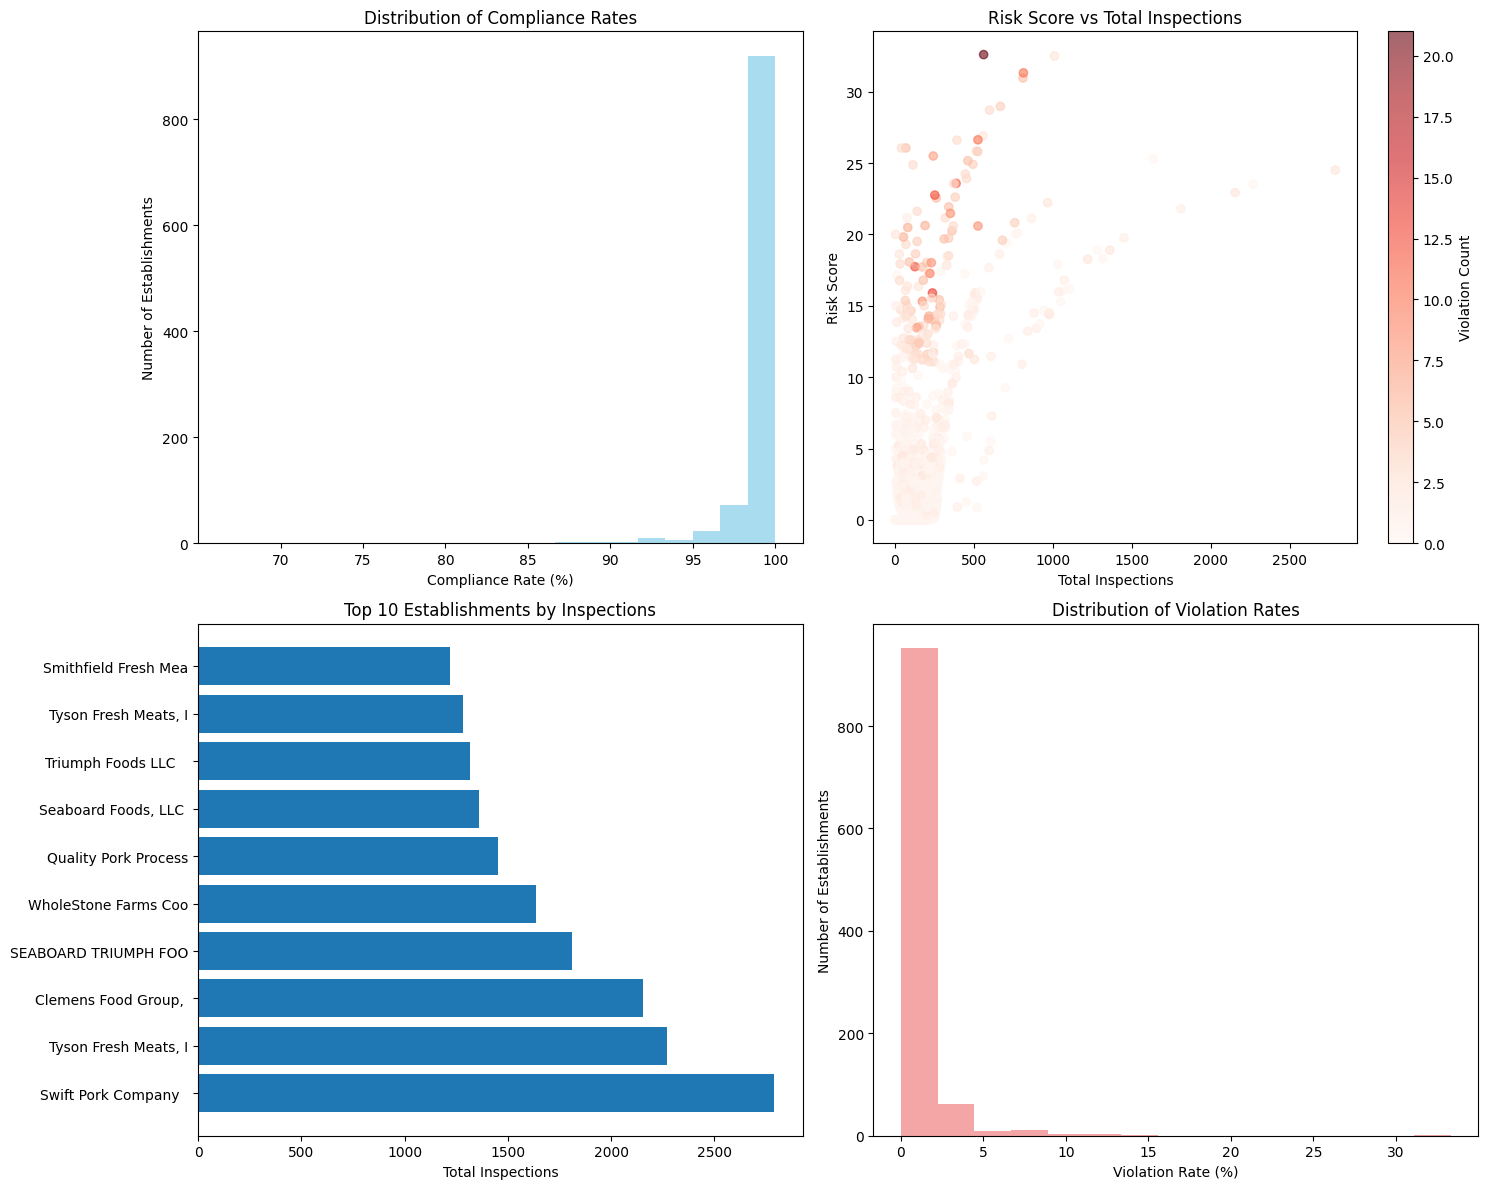

In [19]:
# Create Visualizations

# Performance Distribution Charts

# VISUALIZATION 1: Compliance Rate Distribution
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# Compliance rate histogram
ax1.hist(significant_establishments['ComplianceRate'], bins=20, alpha=0.7, color='skyblue')
ax1.set_title('Distribution of Compliance Rates')
ax1.set_xlabel('Compliance Rate (%)')
ax1.set_ylabel('Number of Establishments')

# Risk score vs total inspections
scatter = ax2.scatter(significant_establishments['TotalInspections'],
                     significant_establishments['RiskScore'],
                     alpha=0.6, c=significant_establishments['ViolationCount'],
                     cmap='Reds')
ax2.set_title('Risk Score vs Total Inspections')
ax2.set_xlabel('Total Inspections')
ax2.set_ylabel('Risk Score')
plt.colorbar(scatter, ax=ax2, label='Violation Count')

# Top 10 by inspections
top_10 = significant_establishments.nlargest(10, 'TotalInspections')
ax3.barh(range(len(top_10)), top_10['TotalInspections'])
ax3.set_yticks(range(len(top_10)))
ax3.set_yticklabels([name[:20] for name in top_10['EstablishmentName']])
ax3.set_title('Top 10 Establishments by Inspections')
ax3.set_xlabel('Total Inspections')

# Violation rate distribution
ax4.hist(significant_establishments['ViolationRate'] * 100, bins=15, alpha=0.7, color='lightcoral')
ax4.set_title('Distribution of Violation Rates')
ax4.set_xlabel('Violation Rate (%)')
ax4.set_ylabel('Number of Establishments')

plt.tight_layout()
plt.show()

In [20]:
# Interactive Risk Assessment Dashboard

# INTERACTIVE PLOTLY DASHBOARD
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=('Risk Score vs Compliance Rate', 'Inspection Volume vs Violations',
                   'Top Risk Establishments', 'Compliance Distribution'),
    specs=[[{"secondary_y": False}, {"secondary_y": False}],
           [{"secondary_y": False}, {"secondary_y": False}]]
)

# Risk vs Compliance scatter
fig.add_trace(
    go.Scatter(
        x=significant_establishments['ComplianceRate'],
        y=significant_establishments['RiskScore'],
        mode='markers',
        text=significant_establishments['EstablishmentNumber'],
        marker=dict(size=significant_establishments['TotalInspections']/2,
                   color=significant_establishments['ViolationCount'],
                   colorscale='Reds',
                   showscale=True),
        name='Establishments'
    ),
    row=1, col=1
)

# Inspection volume vs violations
fig.add_trace(
    go.Scatter(
        x=significant_establishments['TotalInspections'],
        y=significant_establishments['ViolationCount'],
        mode='markers',
        text=significant_establishments['EstablishmentNumber'],
        marker=dict(color='blue', size=8),
        name='Volume vs Violations'
    ),
    row=1, col=2
)

# Top risk establishments
top_risk = significant_establishments.nlargest(10, 'RiskScore')
fig.add_trace(
    go.Bar(
        x=top_risk['RiskScore'],
        y=top_risk['EstablishmentNumber'],
        orientation='h',
        name='High Risk',
        marker_color='red'
    ),
    row=2, col=1
)

# Compliance distribution
fig.add_trace(
    go.Histogram(
        x=significant_establishments['ComplianceRate'],
        nbinsx=20,
        name='Compliance Distribution',
        marker_color='green'
    ),
    row=2, col=2
)

fig.update_layout(height=800, title_text="Establishment Performance Dashboard", showlegend=False)
fig.show()

In [22]:
#  Generate Final Report

# Summary Statistics

# FINAL PERFORMANCE SUMMARY
print("🎯 ESTABLISHMENT PERFORMANCE SUMMARY REPORT")
print("=" * 60)
print(f"Analysis Period: {df['InspectionDate'].min().strftime('%Y-%m-%d')} to {df['InspectionDate'].max().strftime('%Y-%m-%d')}")
print(f"Total Inspections: {len(df):,}")
print(f"Total Establishments: {len(establishment_performance):,}")
print(f"Establishments Analyzed (≥{MIN_INSPECTIONS} inspections): {len(significant_establishments):,}")

print(f"\n📊 KEY METRICS:")
print(f"Average Compliance Rate: {significant_establishments['ComplianceRate'].mean():.1f}%")
print(f"Median Inspections per Establishment: {significant_establishments['TotalInspections'].median():.0f}")
print(f"Establishments with Perfect Compliance: {(significant_establishments['ComplianceRate'] == 100).sum():,}")
print(f"High-Risk Establishments (Risk Score >50): {(significant_establishments['RiskScore'] > 50).sum():,}")

print(f"\n⚠️  ESTABLISHMENTS FLAGGED FOR REVIEW:")
flagged = significant_establishments[
    (significant_establishments['RiskScore'] > 30) |
    (significant_establishments['ViolationCount'] >= 2)
]
print(f"Total Flagged: {len(flagged):,}")

for _, row in flagged.head(5).iterrows():
    print(f"• {row['EstablishmentNumber']}: Risk Score {row['RiskScore']:.1f}, "
          f"{row['ViolationCount']} violations, {row['ComplianceRate']:.1f}% compliance")

🎯 ESTABLISHMENT PERFORMANCE SUMMARY REPORT
Analysis Period: 2023-10-01 to 2024-09-30
Total Inspections: 193,628
Total Establishments: 1,056
Establishments Analyzed (≥5 inspections): 1,042

📊 KEY METRICS:
Average Compliance Rate: 99.3%
Median Inspections per Establishment: 122
Establishments with Perfect Compliance: 682
High-Risk Establishments (Risk Score >50): 0

⚠️  ESTABLISHMENTS FLAGGED FOR REVIEW:
Total Flagged: 162
• M10026: Risk Score 2.1, 2 violations, 99.2% compliance
• M10038+P10038+V10038: Risk Score 14.3, 3 violations, 98.8% compliance
• M10147+P10147+V10147: Risk Score 14.1, 7 violations, 96.7% compliance
• M10252: Risk Score 4.9, 2 violations, 98.9% compliance
• M1052: Risk Score 2.3, 2 violations, 98.3% compliance


In [23]:
# Export Results

# EXPORT RESULTS TO CSV
# Full performance data
establishment_performance.to_csv('establishment_performance_full.csv', index=False)

# High-risk establishments
high_risk_export = significant_establishments[
    significant_establishments['RiskScore'] > 30
].sort_values('RiskScore', ascending=False)
high_risk_export.to_csv('high_risk_establishments.csv', index=False)

# Repeated violators
repeated_violators.to_csv('repeated_violators.csv', index=False)

print("✅ Analysis complete! Files exported:")
print("• establishment_performance_full.csv")
print("• high_risk_establishments.csv")
print("• repeated_violators.csv")

# Download files
files.download('establishment_performance_full.csv')
files.download('high_risk_establishments.csv')
files.download('repeated_violators.csv')

✅ Analysis complete! Files exported:
• establishment_performance_full.csv
• high_risk_establishments.csv
• repeated_violators.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>